#Domestic (US and US territories) Flight Delay Project
## Final Notebook
**w261 Final Project Team 19 Summer 2022**

Team Members: Grace Lee, Shivangi Pandey, Sybil Santos-Burgan, Beijing Wu

# Abstract/Business Case

As travel demand increases in a post-COVID world while supply (in the form of staffing, pilots, etc.) struggles to keep up, it is more important than ever for airports to be prepared for delays. The goal of this study is to help airports with their operations by predicting flight delays so they can be strategic with turnaround services such as aircraft refueling, restocking, baggage handling, air traffic control, and gate management. Using domestic flight, airport, and weather data we will predict departure delays two hours prior to planned departure. We start with EDA and domain research, identifying potential causes for delays and representing these causes via feature engineering. We then create a baseline logistic regression model before using rolling window cross validation on logistic regression, decision tree, and random forest models. We also attempt an ensembling method to try to improve predictions, and evaluate model performance on F2-score, Matthews Correlation Coefficient (MCC), and balanced accuracy to account for the imbalanced nature of departure delays. Our final suggested model is the cross-validated random forest, with F2 score of 0.59, MCC of 0.66, and balanced accuracy of 0.76.

# Introduce Dataset

## Data Description

Our primary data sets are domestic flight and airport data from the U.S. Department of Transportation, weather data from the National Oceanic and Atmospheric Administration repository and stations data also from the US Department of Transportation. The flight dataset contains information about domestic passenger flights on-time performance between 2015 - 2021. The initial dataset contains 107 features, of which the DEP_DEL15 (departure delay 15 minutes or more) field is our target variable.
The weather data set contains hourly weather condition information from 2015-2021. The initial weather dataset contains 177 features. The stations dataset contains station data and its neighbor station along with distance between stations. 

To supplement we also used airline codes, holiday travel and airline operation category datasets. The airline codes dataset from the [Bureau of Transportation Statistics](https://www.bts.gov/topics/airlines-and-airports/airline-codes) provides airline names by IATA code. The holiday dataset also from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/holidaydelay.asp) lists holiday travel seasons as defined by the air travel industry. The carrier category dataset from  https://www.airlinepilotcentral.com/airlines and https://www.icao.int/sustainability/pages/low-cost-carriers.aspx categorizes carriers by their operation cost structures - low-cost carrier (LCC), regional airlnes, and legacy which are typically the major airlines but not LCC.

%md
## Data Dictionary
The following data dictionary includes the final variables we include in the model. These features are a subset of all the features attempted, and were chosen based off of domain knowledge, EDA, and decision tree feature importance.

|Feature|Description | Data Type | Feature Family|
| --- | --- | --- | --- |
| OP_CARRIER |Airline code assigned by IATA and commonly used to identify a carrier | string | categorical |
| DAY_OF_WEEK | Day of the Week. | string | categorical |
| MONTH | Month | string | categorical |
| ORIGIN | Origin Airport | string | categorical |
| DEST | Destination Airport | string | categorical |
| HOLIDAY_IND | Binary indicator if the flight date falls on a holiday. Holiday travel seasons are defined by the air travel industry and availble from Bureau of Transportaiton Statistics (BTS). | integer | categorical |
| PRE_HOLIDAY_IND | Binary indicator if the flight date falls within the holiday season but before the actual holiday. | integer | categorical |
| POST_HOLIDAY_IND | Binary indicator if the flight date falls within the holiday season but after the actual holiday. | integer | categorical |
| DISTANCE | Distance between airports (miles) | double  | numeric |
| VisibilityAvg | Visibility (in meters) averaged over 2-hour window prior to the time indicated | double  | numeric |
| WindSpeed Avg | Wind speed (in meters per second) averaged over 2-hour window prior to the time indicated | double  | numeric |
| DewPointAvg | Dew point temperature (in Degrees Celsius) averaged over 2-hour window prior to the time indicated | double  | categorical |
| OvercastIndex | Overcast weather indicator | double | categorical |
| DISTANCE | Distance between airports (miles) | double | numeric |
| carrier_cat | Through our previous EDA, we discovered there was a trend of low cost airlines having higher % of flights delayed, major airlines having less delays, and regional airlines having even less delays. We obtained the carrier categories off of https://www.airlinepilotcentral.com/airlines and https://www.icao.int/sustainability/pages/low-cost-carriers.aspx  | string | categorical |
| PRIOR_FLIGHT_LATE_ARRIVAL |Our hypothesis is that prior flight information will improve prediction of departure delays. This variable is a binary indicator of whether the plane arrived over 30 min late from its previous flight. 30 minutes was chosen because flights may be able to make up time during flight, but not if the delay is too late.  | integer | categorical |
| origin_airport_pagerank | Busy airports may be more likely to have delays. This is a variable indicating the importance of an airport. The values in this feature are the relative pagerank importance of the airport | double | numeric |

## Notebook Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Window

import time

from scipy import stats
from scipy.stats import norm

pd.options.display.float_format = '{:.0f}'.format
from pyspark.sql.functions import col
from pyspark.sql.functions import col, max

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from pyspark.sql.functions import col,isnan,when,count
from graphframes import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import math
import itertools 
import random

#Set up blob access
blob_container = "261finalproject" # The name of your container created in https://portal.azure.com
storage_account = "ssburgan" # The name of your Storage account created in https://portal.azure.com
secret_scope = "261finalprojectscope1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "bestteam" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/,parquet_airlines_data/,0,1656618287000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/,parquet_airlines_data_1y/,0,1656630272000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0,1656630114000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0,1656630205000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/,parquet_weather_data/,0,1656622074000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/,parquet_weather_data_1y/,0,1656631614000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/,parquet_weather_data_3m/,0,1656630651000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/,parquet_weather_data_6m/,0,1656631047000
dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/,stations_data/,0,1656713663000


In [0]:
#Read in full joined dataset 
df_join = spark.read.parquet(f"{blob_url}/base_datasets/final_joined_data")
print('initial row count:', df_join.count())

# Fill cancelled missing values in delayed column (because missing when flight cancelled, consider cancels as delays)
df_join.na.fill({'DELAYED': 1})

#Read in airline names dataset
df_airline_names = spark.read.parquet(f"{blob_url}/airline_names")
df_airline_names = df_airline_names.withColumnRenamed("Code", "Airline_Code")
df_airline_names = df_airline_names.withColumnRenamed("Description", "Airline_Description")

#Read in carrier cateogry LCC, Regional, Legacy
df_carrier_cat = spark.read.parquet(f"{blob_url}/carrier_cat_US")

#Add Hour Column
df_join = df_join.withColumn("HOUR", F.substring('CRS_DEP_TIME', 0, 2))

#Join Airline Description
df_join = df_join.join(df_airline_names, df_join.OP_CARRIER == df_airline_names.Airline_Code, "inner") 

#Join Carrier Category
df_join = df_join.join(df_carrier_cat, df_join.Airline_Code == df_carrier_cat.carrier_cat_IATA, "left") 
#Drop uncessary carrier category columns
df_join = df_join.drop(F.col("carrier_cat_airline"))
df_join = df_join.drop(F.col("carrier_cat_region"))

#Holiday data
df_holidays = spark.read.parquet(f"{blob_url}/holiday_travel_season")

# Prep holiday date column to be in correct format to join
df_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Date'), '/(.*)/', 1))
df_holidays = df_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_holidays = df_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_holidays = df_holidays.withColumn('Date_to_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep pre holiday date column to be in correct format to join
df_pre_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Start_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Start_Date'), '/(.*)/', 1))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Pre_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep post holiday date column to be in correct format to join
df_post_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_End_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_End_Date'), '/(.*)/', 1))
df_post_holidays = df_post_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Post_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# convert holiday date_to_join to datetime and add pre and post holiday date benchmarks (7 days prior and after)
df_holidays = df_holidays.withColumn('HOLIDAY_DATETIME', F.unix_timestamp(df_holidays.Date_to_join,"yyyy-MM-dd").cast('timestamp'))
df_pre_holidays = df_pre_holidays.withColumn('PRE_HOLIDAY_DATETIME', F.unix_timestamp(df_pre_holidays.Pre_holiday_join,"yyyy-MM-dd").cast('timestamp'))
df_post_holidays = df_post_holidays.withColumn('POST_HOLIDAY_DATETIME', F.unix_timestamp(df_post_holidays.Post_holiday_join,"yyyy-MM-dd").cast('timestamp'))

# join holidays to full data
df_join = df_join.join(df_holidays.select('Date_to_join', 'Holiday_Desc'), df_join.FL_DATE == df_holidays.Date_to_join, "left")
df_join = df_join.join(df_pre_holidays.select('Pre_holiday_join', 'PRE_HOLIDAY_DATETIME'), df_join.FL_DATE == df_pre_holidays.Pre_holiday_join, "left")
df_join = df_join.join(df_post_holidays.select('Post_holiday_join', 'POST_HOLIDAY_DATETIME'), df_join.FL_DATE == df_post_holidays.Post_holiday_join, "left")

# HOLIDAYS: create indicator for holiday, and pre and post holiday
df_join = df_join.withColumn('HOLIDAY_IND', F.when(F.col('Holiday_Desc').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('PRE_HOLIDAY_IND', F.when(F.col('Pre_holiday_join').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('POST_HOLIDAY_IND', F.when(F.col('Post_holiday_join').isNotNull(), 1).otherwise(0))

# Did the prior flight arrive late? create feature if prior flight arrived over 30 min late
df_join=df_join.withColumn('PRIOR_FLIGHT_LATE_ARRIVAL',F.when(F.col('ARR_DELAY')>30,1).otherwise(0))

# Graphframes Pagerank airport variable origin_airport_pagerank
nodes = df_join.select('ORIGIN').withColumnRenamed('ORIGIN', 'id').distinct()
edges = df_join.withColumn('flight_id', F.monotonically_increasing_id()).select(F.col('DELAYED'), F.col('ORIGIN').alias('src'), F.col('DEST').alias('dst'))
graph = GraphFrame(nodes, edges)
airport_ranks = graph.pageRank(resetProbability = 0.15, maxIter = 10)
ordered_airport_ranks = airport_ranks.vertices.orderBy(airport_ranks.vertices.pagerank.desc())
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('id', 'pagerank_id')
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('pagerank', 'origin_airport_pagerank')

df_join = df_join.join(ordered_airport_ranks, df_join.ORIGIN == ordered_airport_ranks.pagerank_id, 'left')

# make sure joins did not duplicate any records
print('end row count', df_join.count())
display(df_join)

initial row count: 42430592
end row count 42430592

DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,QUARTER,DEP_DEL15,YEAR,MONTH,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_CITY_MARKET_ID,DEST,CRS_DEP_TIME,ARR_DELAY,DIVERTED,DISTANCE,CANCELLED,DELAYED,FlightDepartTimestamp,FlightDepartUTCTimestamp,FlightDepartUTCTimestampHrTrunc,ICAO,STATION,OvercastIndex,WindSpeedAvg,DewPointTempAvg,VisibilityAvg,WEATHER_ROUND_DATE,twoHoursBeforeDeparture,weatherUTCTimestamp,HOUR,Airline_Code,Airline_Description,carrier_cat_ICAO,carrier_cat_IATA,carrier_cat,Date_to_join,Holiday_Desc,Pre_holiday_join,PRE_HOLIDAY_DATETIME,Post_holiday_join,POST_HOLIDAY_DATETIME,HOLIDAY_IND,PRE_HOLIDAY_IND,POST_HOLIDAY_IND,PRIOR_FLIGHT_LATE_ARRIVAL,pagerank_id,origin_airport_pagerank
9,5,N764AS,1,1.0,2015,1,2015-01-09,AS,BET,30113,ANC,0825,40.0,0.0,399.0,0.0,1,2015-01-09T08:25:00.000+0000,2015-01-09T17:25:00.000+0000,2015-01-09T17:00:00.000+0000,PABE,70219026615,0.0,10.369901946852352,31.003862660944208,7.379172924800487,2015-01-09 15:00:00,1420815600,1420815600,08,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,1,BET,0.26754135479495855
21,3,N768AS,1,0.0,2015,1,2015-01-21,AS,BET,30113,ANC,1329,-17.0,0.0,399.0,0.0,0,2015-01-21T13:29:00.000+0000,2015-01-21T22:29:00.000+0000,2015-01-21T22:00:00.000+0000,PABE,70219026615,0.0,10.262080727686186,28.619919862621636,7.424709620385293,2015-01-21 20:00:00,1421870400,1421870400,13,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
8,5,N713AS,2,0.0,2015,5,2015-05-08,AS,BET,30113,ANC,2110,-5.0,0.0,399.0,0.0,0,2015-05-08T21:10:00.000+0000,2015-05-09T05:10:00.000+0000,2015-05-09T05:00:00.000+0000,PABE,70219026615,0.0,11.791684465328208,15.634911580148318,7.5394552639727666,2015-05-09 03:00:00,1431140400,1431140400,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
1,3,N713AS,3,0.0,2015,7,2015-07-01,AS,BET,30113,ANC,2110,-6.0,0.0,399.0,0.0,0,2015-07-01T21:10:00.000+0000,2015-07-02T05:10:00.000+0000,2015-07-02T05:00:00.000+0000,PABE,70219026615,1.0,11.650428571428572,23.38246215367038,8.333929604298948,2015-07-02 03:00:00,1435806000,1435806000,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
23,3,N762AS,4,1.0,2015,12,2015-12-23,AS,BET,30113,ANC,2103,29.0,0.0,399.0,0.0,1,2015-12-23T21:03:00.000+0000,2015-12-24T06:03:00.000+0000,2015-12-24T06:00:00.000+0000,PABE,70219026615,0.0,11.836175049730038,34.48455681654934,7.6336627853586645,2015-12-24 04:00:00,1450929600,1450929600,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
4,5,N763AS,1,1.0,2016,3,2016-03-04,AS,BET,30113,ANC,2103,18.0,0.0,399.0,0.0,1,2016-03-04T21:03:00.000+0000,2016-03-05T06:03:00.000+0000,2016-03-05T06:00:00.000+0000,PABE,70219026615,0.0,13.619448807653862,23.548285714285715,8.266514484250234,2016-03-05 04:00:00,1457150400,1457150400,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
29,5,N763AS,3,0.0,2016,7,2016-07-29,AS,BET,30113,ANC,2100,4.0,0.0,399.0,0.0,0,2016-07-29T21:00:00.000+0000,2016-07-30T05:00:00.000+0000,2016-07-30T05:00:00.000+0000,PABE,70219026615,1.0,13.24763406940063,33.77862157902278,8.81096488266394,2016-07-30 03:00:00,1469847600,1469847600,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
7,7,N763AS,3,0.0,2016,8,2016-08-07,AS,BET,30113,ANC,2100,-10.0,0.0,399.0,0.0,0,2016-08-07T21:00:00.000+0000,2016-08-08T05:00:00.000+0000,2016-08-08T05:00:00.000+0000,PABE,70219026615,0.0,12.617457359896804,36.5042257556224,8.700731003838717,2016-08-08 03:00:00,1470625200,1470625200,21,AS,Alaska Airlines Inc.,ASA,AS,Legacy,null,null,null,null,null,null,0,0,0,0,BET,0.26754135479495855
9,5,N768AS,4,0.0,2016,12,2016-12-09,AS,BET,30113,ANC,2105,1.0,0.0,399.0,0.0,0,2016-12-09T21:05:00.000+0000,2016-12-10T06:05:00.000+0000,2016-12-10T06:00:00.000+0000,PABE,70219026615,0.0,10.396578759800427,38.36156817856631

# EDA & Feature Engineering

For our initial EDA, we looked at the distributions and missing values of each independent dataset to identify if there was extra information that needed to be recoded. From this analysis, we concluded that most of the data was actually missing with some exceptions (see below table). If columns were significantly missing we did not use those columns: 

| Feature | Notes about Missing | Accounting for Missing |
| --- | --- | --- |
| DEP_DELAY15 | All missing values are due to cancelled flights | Consider cancels as extended delay: recode nulls as 1 |
| ARR_DELAY | missing when cancelled or diverted | We need this column for information about prior flight delay |
| AIR_TIME | Null for diverted and cancelled flights | Did not use this column because highly correlated with distance |
| TAIL_NUM | Only missing when flights cancelled | We need this column for information about prior flight delay |
|Various weather variables | Some have different coded numbers (like 99999) | Through domain research, we discovered very few of the weather variables would impact flights. For example, anything affecting visibility. The relevant variables that potentially would cause weather delays did not have such coded values, and these variables would be aggregated within a 2 hour window prior to our prediction time. |

#### New Feature: Carrier Category (categorical)
After joining the data, we conducted some additional EDA (see code blocks below). We noticed that there was a clear trend in certain airline carriers having a higher % of delayed flights. We did some extra external research and discovered that many of the carriers that have higher % delayed are considered low cost (JetBlue) or ultra-low cost carriers (Spirit, Frontier) while other airline categories had fewer % delayed. We created a carrier category feature to account for this discovery and included this new feature in our models. 

#### New Feature: Holidays: Pre and Post season (binary)
Airline travel can be seasonal, and certain holidays have much higher traffic than normal. We found a holiday dataset from the Bureau of Transportation Statistics that contains the dates of holidays as well as the air industry's defined "start" and "end" to that holiday's travel season. Using this information, we created three binary indicators for flights on the dates that were holidays, pre-holiday, and post-holiday. 

#### New Feature: Airport importance (pagerank) (numerical)
Certain airports can be considered "hubs" and might have much more activity (potentially causing delays) than others. We used pagerank to find the importance of each airport, and created a new feature using the pagerank importance for each flight's origin airport to try to capture information about how busy the airport is, as this might affect departure timeliness. The most important airport found by pagerank is ATL, ORD and DFW. 

#### New Feature: Prior Flight's Late Arrival (binary)
We believe there is a chaining effect of late arriving flights causing future delayed flights, and we hypothesize that this will be the most important impact on flights departing late. We tracked each flight's tail number, and created a binary feature indicating whether the plane used in each flight arrived late. We also did external research and found that there is some room to "make up" time, so we only considered flights arriving more than 30 minutes late as late enough to affect the next flight's departure delay.

In [0]:
dbutils.data.summarize(df_join)

<!DOCTYPE html>

Out[10]:

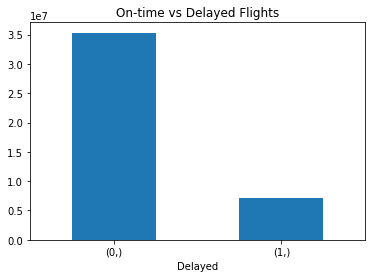

<AxesSubplot:title={'center':'On-time vs Delayed Flights'}, xlabel='Delayed'>

In [0]:
df_join.select('Delayed').toPandas().value_counts().plot.bar(title = "On-time vs Delayed Flights", legend = False, rot = 0)

Out[10]:

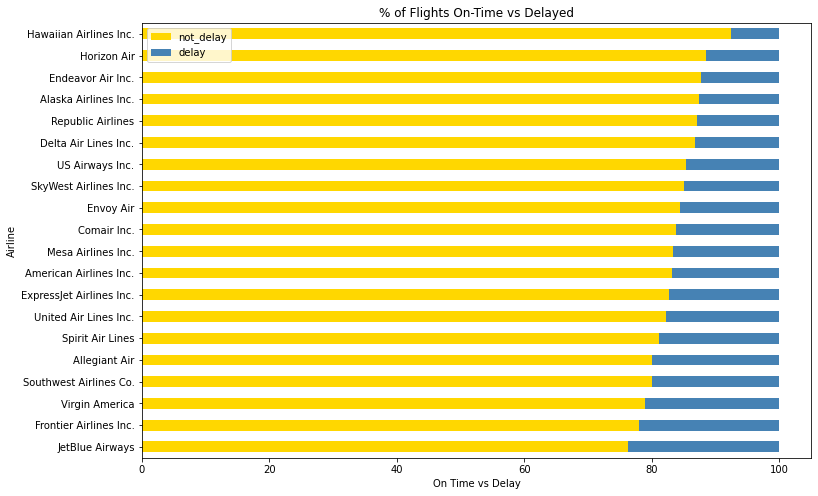

Text(0, 0.5, 'Airline')

In [0]:
from matplotlib.colors import ListedColormap

df_join.createOrReplaceTempView("airline")
df_delay = spark.sql("select Airline_Description \
                     ,AVG(case when DELAYED = 0 then 1 else 0 end)*100 as not_delay \
                     ,AVG(case when DELAYED = 1 then 1 else 0 end)*100 as delay \
                     from airline group by Airline_Description order by delay desc ")

cmp = ListedColormap(['gold', 'steelblue'])

df_delay.toPandas().plot(
    x = 'Airline_Description',
    kind = 'barh',
    stacked = True,
    title = '% of Flights On-Time vs Delayed',
    colormap = cmp,
    mark_right = True, figsize=(12,8))

plt.xlabel('On Time vs Delay')
plt.ylabel('Airline')

Out[4]:

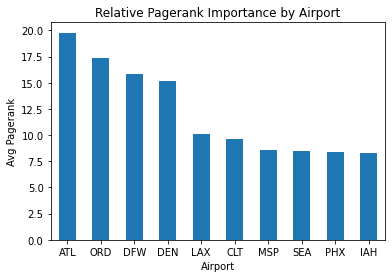

<AxesSubplot:title={'center':'Relative Pagerank Importance by Airport'}, xlabel='Airport', ylabel='Avg Pagerank'>

In [0]:
#Relative Pagerank Importance by Airport
df_join.createOrReplaceTempView("airport")
df_airport_page_rank = spark.sql("select pagerank_id as airport, avg(origin_airport_pagerank) as avg_page_rank from airport group by pagerank_id order by avg_page_rank desc  LIMIT 10")
df_airport_page_rank.toPandas().plot.bar(title = "Relative Pagerank Importance by Airport", y='avg_page_rank',x='airport', xlabel='Airport', ylabel='Avg Pagerank', legend = False, rot = 0) 

Out[7]:

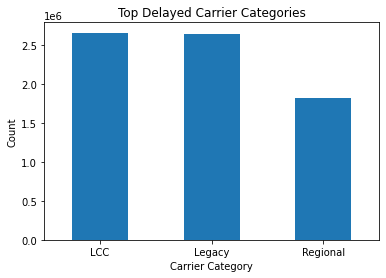

<AxesSubplot:title={'center':'Top Delayed Carrier Categories'}, xlabel='Carrier Category', ylabel='Count'>

In [0]:
# Carrier Categories
df_join.createOrReplaceTempView("airport")
df_carrier_categories = spark.sql("select carrier_cat as carrier, count(carrier_cat) as carrier_count from airport where DELAYED = 1 group by carrier_cat order by carrier_count desc LIMIT 5")
df_carrier_categories.toPandas().plot.bar(title = "Top Delayed Carrier Categories", y='carrier_count',x='carrier', xlabel='Carrier Category', ylabel='Count', legend = False, rot = 0) 

Out[7]:

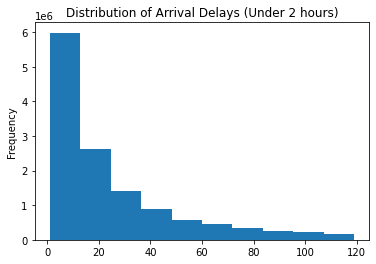

<AxesSubplot:title={'center':'Distribution of Arrival Delays (Under 2 hours)'}, ylabel='Frequency'>

In [0]:
# Distribution of Prior Flight late Arrival (ARR_DELAY)
df_join.filter((F.col('ARR_DELAY')> 0) & (F.col('ARR_DELAY') < 120) ).select('ARR_DELAY').toPandas().plot.hist(title = 'Distribution of Arrival Delays (Under 2 hours)', xlabel = 'minutes', legend = False)  

%md
## Feature Selection

To remove irrelevant features that do not contribute much to our target variable prediction, we reviewed feature importance from our Decision Tree model. We found the following features most significantly reduced tree impurity and were the largest drivers of predicting departure delay:

 
#### Features to Keep
* PRIOR_FLIGHT_LATE_ARRIVAL
* carrier_cat
* OP_CARRIER
* origin_airport_pagerank
* DISTANCE
* ORIGIN
* DEST
* VisibilityAvg

<img src="https://drive.google.com/uc?id=1nntAXYx23tLaDY95lWHic5RPO_hxy55E" alt="Decision Tree Feature Importance" />

# Algorithms Attempted

## Logistic Regression

We attempted logistic regression for baseline model for its simplicity in comprehension and implementation. Logistic regression performs binary classification by estimating the probability of an event occurring, i.e. whether a flight is delayed or not delayed. It models a dependent variable (Y) in terms of one of more independent variables (X). The basis of the logistic regression is the logistic fuction, which takes a linear function as input.
$$\hat{y} = \frac{1}{1+exp^{-x}} $$ where $$x = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 +\cdots + \beta_nx_n$$

Since the outcome is a probability, the dependent variable (Y) is bounded between 0 and 1. Given our outcome variable (`DEP_DEL15`) is binary, the algorithm becomes a natural choice for us to explore. The decision for converting a predicted probability into a class label is decided by the threshold, where a probabilitiy value above the threshold indicates one class while the one below indicates the other class. 

We used `StandardScaler` to scale and normalize numeric features and used `OneHotEncoder` to tranform and encode categorical features. Instead of optimizing the log loss function, where

$$ cost(h_\theta(x), y) = -y log(h_\theta(x)) - (1-y) log(h_\theta(x))$$
we added constraint on how big the coefficients can get, with regularization, in order to prevent overfitting. L1, Lasso regularization, has the ability for feature selection by making coefficients equal to 0 for less important features. L2, Ridge regularization, penalizes large coefficients. `elasticNetParam` is a mixture of L1 and L2 regularization, and when it is set to 1, it uses L1 regularization, whereas when it is set to 0, it uses L2 regularization. When `regParam` is set to 0, it means no penalty for regularization.

The advantage of using Logistic Regression is that it not only provides a measure of how appropriate a predictor (coefficient size) is, but it also gives direction of association (positive or negative). However, the major limitation of Logistic Regression is the assumption of linearity between the dependent and the independent variables. In the context of our business case, we are assuming flight delay has linear relationships with selected features, such as airline, weather, flight origin and destination, etc.

## Decision Tree

Because of the assumption of linearity between dependent and independent variables for Logistic Regression, we decided to explore tree-based models.

Decision tree continuously splits the data according to a certain parameter, and it consists of nodes, where the data is split, and leaves, which are the terminal notes that predict the outcome. A classification decision tree is built through binary recursive partitioning, which is a divide and conquer approach as the data is splitted into subsets, which are further splitted into smaller subsets, until the process stops when the algorithm decides that the data within subsets are sufficiently homogenous or a stopping criterion has been met. To prevent overfitting, the depth of the tree (i.e., `maxDepth`) is usually limited, compromising on purity as the final leaves may still have impurity, which is measured using Gini impurity shown below. Given k classes, the probability of samples belonging to class i at a given node is denoted with p: 

$$ Gini = 1 - \sum_{i = 1}^{k}p_i^2$$

The advantage of using Decision Tree for classification is that it is computationally inexpensive to construct and fast at classifying, is easy to interpret because it excludes features that are not important. The major disadvantage is that Decision Tree algorithm is prone to overfitting, is biased towards splits on features having a large number of depths, and is sensitive to changes in training dataset.

## Random Forests

Random Forests are a collection of decision trees being grouped and trained together that use random orders of the features in the given dataset. Instead of relying on one tree, random forest takes the prediction from each and every tree, and the final outcome is based on the majority of the votes of the predictions. Unlike decision trees that are extremely sensitive to data they are trained on as small changes in training data can result in significantly different tree structures, random forest takes advantage of this by allowing each tree to randomly sample from the data with replacement, resulting in different tress. Random forest is an ensemble method, and it is designed to improve model's predictive power.

The advantage of random forest is that it is highly accurate in classification, runs efficiently on large dataset, and estimates feature importance. The disadvantage is that random forests can be slow to predict and are biased in favor of those features with more levels. In addition, the algorithm might identify the same certain features significantly reducing impurity which may cause similar splits, resulting in ensembling similar trees and missing some complex relationships.

## Gradient Boosted Trees

Gradient Boosted Trees are an alternate tree algorithm, where trees are very short "weak learners" but are improved through a successive learning process. Unlike random forest where trees are built independently and then combined in parallel, gradient boosted trees are built sequentially, with new tree "stumps" correcting the error of the previous, already built trees. 

The advantage of gradient boosting is that they can model complex relationships as a result of correcting prior tree errors. The disadvantage, however, is that this can cause overfitting with the algorithm modeling noise into its error corrections.

## Leakage
These are the hypothetical examples of leakage that we are avoiding: 
- Only consider data available 2 hours before flight departure (only have 'past' information for predictions)
- Do not have test data while training and tuning models

We avoid these leakage issues by first splitting train/test data by year, with the 2021 test data never touched until the end. Even for our cross validation we only use data from 2015 - 2020. We also avoid predicting "future" information by ensuring that the join only contains data that is 2 hours minimum prior to the CRS departure time.

# Final Pipeline

## Split Train/Test

Because we are dealing with time series data, preventing data leakage is extremely important. Instead of a random split, we used data from 2015 - 2020 for training and validation and held out data from 2021 for blind testing.

* Number of rows in training set 2015-2020: 36,435,195
* Number of rows in blind test set 2021: 5,995,397

## Time Series Rolling Window Grid Search Cross Validation

Notebook: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/388464713030334/command/388464713030353

#### Rolling Window Approach and Class Imbalance

We decided to use rolling window approach for time series split cross validation. First, we sorted the dataset based on timestamp, and then divided the training data into 5 equal folds such that each fold contains the same number of rows. Within each fold, the first 80% of the records are used for training, and the rest 20% are used for validation. The splitted train-validation sets were stored in blob for fast retrieval during model training.

<img src="https://www.researchgate.net/publication/349744149/figure/fig20/AS:997378383441922@1614804945420/Blocked-cross-validation-with-three-splits.ppm"
    alt="Rolling Window Time Series Split"
    style="float: left; margin-right: 10px;" />

Image Source: https://www.researchgate.net/figure/Blocked-cross-validation-with-three-splits_fig20_349744149

Because most of the machine learning algorithms used for classification are designed around the assumption of an equal number of examples for each class, imbalanced classes pose a challenge for predictive modeling, specifically for the minority class, where the minority class is typically of the most interest and is more sensitive to classification errors. The minority class is harder to predict because by definition, there are fewer examples of this class in the training data. This means that it is more challenging for a model to learn the characteristics of examples from this class and to differentiate examples of this class from the majority class. Because class imbalance is observed in our dataset where only 30% of the flights are `DELAYED`, we downsampled the majority class using function `down_sampling`, only on the training data, based on the ratio between the majority (not delayed) and the minority (delayed) class. The validation and blind testing datasets are untouched.

#### Hyperparameter Tuning with Time Series Grid Search CV

Hyperparameter tuning of model parameters was achieved using custom grid search cross validation functions to test combinations of any set of model parameters. We opted out of using the `CrossValidator` from PySpark because it shuffles the data, and would cause data leakage as future records could end up in the training set and predictions could be made of the past observations. Our `kfold_data` function splits the full training data into train-validation subsets while keeping the flight dates ordered sequentially.

<img src="https://drive.google.com/uc?id=1C-0JeSLSNWLSn0PqMO3mapIP8lnXt2Yp" alt="Rolling Window Time Series Split"/>

We used a `custom_cv` function to train each model for a combinations of grid search parameters on each train-validation split. The `parameter_sets` function combines `parameter_grid` into all possible permutations of dictionary values, which were then passed to the respective model for training. For Logistic Regression and Gradient Boosted Tree models, we manually specified a subset of the hyperparameter values to be used in gird search; for Random Forest and Decision Tree, we attempted random search by selecting the combinations of hyperparameter values randomly. As an example, we specified 6 values for `elasticNetParam` and 3 values for `regParam` to be used in grid search for Logistic Regression, and there were 18 possible combinations between these two parameters, hence a total of 18 Logistic Regression models were trained. Practically speaking, the number of parameter combinations can increase exponentially as more values are added, which in turn can result in massively increased training time.

After training on each train-validation split, the model performance was evaluated on the respetive validation set using the function `model_eval`. To select the best parameter combination, the average values of the F2 scores from the 5 train-validation splits were compared, and the parameter combination that resulted in the highest F2 score average was then outputed, along with the F2 score average, by the pipeline.

| model | cv_fold | parameter_grid | num_model | best_parameters | F2 | run time (32 GB, 8 cores) | 
| --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | 5 | {'maxIter': [10], 'elasticNetParam':[0, 0.001, 0.01, 0.1, 0.5, 1], 'regParam': [0, 0.001, 0.1]} | 18 | {'maxIter': 10, 'elasticNetParam': 1, 'regParam': 0.1} | 0.6202 | 13.61 hrs |
| Random Forest | 5 | {'numTrees': random.sample(list(range(10, 500)), k = 4), 'maxDepth': random.sample(list(range(2, 15)), k = 2)} | 8 | {'numTrees': 338, 'maxDepth': 3} | 0.6222 | 8.52 hrs |
| Decision Tree | 5 | {'maxDepth': random.sample(list(range(2, 15)), k = 2), 'maxBins': random.sample(list(range(20, 500)), k = 3)} | 6 | {'maxDepth': 5, 'maxBins': 32} | 0.6201 | 6.74 hrs |
| Gradient Boosted Tree | 5 | {"maxIter":[25, 75], "minInstancesPerNode":[1, 5], "maxDepth":[1, 2], "maxBins":[128], "stepSize":[0.1]} | 8 | {"maxIter":25, "minInstancesPerNode": 1, "maxDepth": 1, "maxBins": 128, "stepSize": 0.1} | 0.6224 | 22.70 hrs |

# Evaluation Metrics to Measure Success
We compared model results using the following four metrics to evaluate the model performance: 

##### F2 Score
F2 score is a weighted harmonic mean of precision and recall. This metric gives more weight to recall than to precision, which means False Positives are considered better than False Negatives, which is what we think is important for flight delays.   
$$ F_2 Score = 5(\frac{Precision * Recall}{4Precision + Recall}) $$
$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN} $$

##### MCC (Matthews Correlation Coefficient)
This metric represents the confusion matrix as a single number, and helps with imbalanced data. MCC takes into account the proportion of each class. This metric ranges from -1 to 1, and -1 indicates the model is predicting the opposite class from the actual value, 0 is similar to random guessing, and 1 indicates a perfect classification.
$$ MCC = \frac{TP * TN - FP * FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

##### Balanced Accuracy
Since the data is imbalanced, a normal accuracy metric will be high just by predicting the majority class, which is misleading. We instead will use balanced accuracy which takes into account different class sizes. 
$$ Balanced\ Accuracy = \frac{sensitivity + specificity}{2}$$
$$ Sensitivity = \frac{TP}{TP + FN}$$
$$ Specificity = \frac{TN}{TN + FP}$$

# Performance and Scalability

## Baseline Model Results
The baseline model was a logistic regression model on airline carrier, hour, month, and visibility with some minor grid-search cross validation. 

| | Input features | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- |
| Train | OP_CARRIER, HOUR, MONTH, VisibilityAvg | 0.317 |  -0.213 | 0.394 |
| Test | OP_CARRIER, HOUR, MONTH, VisibilityAvg | 0.227 |  -0.161 | 0.392 |

## Model Performance Results on Test Set

Notebook: https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/849916349900735/command/849916349900775

To test model performance on test set, the full training set (i.e., 2015 - 2020) was first downsampled using `down_sampling` function to balance the majority (not delayed) and minority (delayed) classes. Then each model was trained on the downsampled training set before being tested on the blind test set (2021). The predictions from each model were stored on blob. In addition, in the hope to improve model performance, we attempted a voting ensemble of the predictions from all models, where equal weights were given to each individual model's predictions, the predictions from each model are summed and the class with the unanimous vote was predicted.

#### Logistic Regression
| | Input features | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'OvercastIndex', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg', 'DewPointTempAvg' |0.588823201 | 0.659629926 | 0.764984149|

CV Time: 13.6 hours, Train/Prediction Time: 6.5 min

####  Decision Tree
| | Input features | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'OvercastIndex', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg', 'DewPointTempAvg' | 0.588630976 | 0.659482722 | 0.76488423 |

CV Time: 6.7 hours, Train/Prediction Time: ~20.4 min

####  Random Forest
| | Input features | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'OvercastIndex', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg', 'DewPointTempAvg' |0.588843146 | 0.659481563 | 0.764985323 |

CV Time: 8.5 hours, Train/Prediction Time: ~27.6 min

####  Ensemble
| | Input features | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'OvercastIndex', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg', 'DewPointTempAvg' |0.560733606 | 0.359583461 | 0.713397723 |

Wall Time: 3 min

The Logistic Regression, Decision Tree, and Random Forest models have similar F2 scores around 0.59, MCC around 0.66, and Balanced Accuracy around 0.76, when tested on blind testing data. Overall, all three models have improved compared to the baseline, indicating that by adding features such as prior flight delay, importance of the airports, and weather information, our models could successfully identify relationships in the data and have predictive power in identifying departure delays. 

The F2 scores were slightly lower (around 3%) than those were obtained during cross validation (F2 scores around 0.62). The reason that lower than training F2 scores were observed was because the training F2 score was an average across the 5 CV folds, and shown in the table below using Logistic Regression as an example, model performance was slightly different between each of the training-validation split. To account for this effect, one potential improvement that could be done in the future was to give more weight to more recent data, especially that flight delay causes may be different compared to previous years because of COVID.

| Logistic Regression | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- |
| CV_fold_0 | 0.5926 | 0.6656 | 0.7674 |
| CV_fold_1 | 0.6366 | 0.6866 | 0.7886 |
| CV_fold_2 | 0.6615 | 0.6990 | 0.8010 |
| CV_fold_3 | 0.6585 | 0.6971 | 0.7995 | 
| CV_fold_4 | 0.5626 | 0.6479 | 0.7556 |
| Test | 0.5888 | 0.6596 | 0.7650 |

MCC for the test data set was comparable to CV results and was around +0.66, indicating that our models were predicting in the correct direction, and were doing much better than random guessing (MCC = 0). Balanced accuracy was also comparable between CV and test set, around 0.76, indicating that our models did a good job of predicting whether or not a flight would be delayed in departure. To further improve these models, more data or additional feature engineering is likely to be required.

<img src="https://drive.google.com/uc?id=1ZVrEIavRJBMCtRzqdICAuW73QABhLGzN" alt="Confusion Matrix" />

## Notes on the Ensemble Model

In the hope to further improve model performance, we attempted a voting ensemble of the predictions from all models, where equal weights were given to each individual model's predictions, the predictions from each model are summed and the class with the unanimous vote was predicted. By taking into consideration of the predictions from all models, we hope to leverage insights gained from each of the models as each model has its own advantages and disadvantages. For example, Logistic Regression captures linear relationship between dependent and independent variables, whereas tree-based models are better at dealing with non-linear relationships.

Our ensemble model took the predictions from each of the three models (i.e., Logistic Regression, Random Forest, and Decision Tree), and the predictions were summed. If all three models predicted departure delay (sum = 3), the ensemble model would predict delay and would not predict delay otherwise. This improved the predicting power of the ensemble model for flight departure delays as shown in the table below, the true positive count for ensemble model was the highest, and recall, which indicates the percentage of predicted positive out of total positive, was the lowest. However, the downside is the high false positive count and hence low precision score. We also attempted using majority vote from the three models (sum >= 2) to predict delay for ensemble model (detailed results not shown), and we noticed that the true positive count for ensemble model was extremely low. This suggested that our individual models were making the same mistake when predicting departure delay, and when taking majority vote, the mistake was exaggerated, resulting in low true positive count for the ensemble model. Our goal was to predict departure delay, and without the ability to successfully predict departure delay, the model cannot be considered. Therefore, we chose to use the unanimous voting system for our ensemble model.


| model | TP | TN | FP | FN | precision | recall | specificity | F2 | MCC | Balanced Accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | 554569 | 4914771 | 55981 | 470076 | 0.9083 | 0.5412 | 0.9887 | 0.5888 | 0.6596 | 0.7650 |
| Random Forest | 554625 | 4914511 | 56241 | 470020 | 0.9079 | 0.5413 | 0.9887 | 0.5888 | 0.6595 | 0.7650 |
| Decision Tree | 554363 | 4914777 | 55975 | 470282 | 0.9082 | 0.5410 | 0.9887 | 0.5886 | 0.6595 | 0.7649 |
| Ensemble | 644906 | 3963682 | 1007070 | 379739 | 0.3904 | 0.6294 | 0.7974 | 0.5607 | 0.3596 | 0.7134 |

# Final Model
We suggest the Random Forest model as the final prediction model. Even though the logistic regression, decision tree, and random forest had similar evaluation scores, we believe the random forest out performs the others with decent runtime, the ability to model more complex relationships, and the ability to demonstrate feature importance. The important features causing departure flight delay for airports to be aware of as indicated by the random forest, shown in figure below, are prior flight delay information, low-cost airlines (with JetBlue (B6) in particular as an important feature), airport pagerank importance (where the top pagerank airports are Hartsfield-Jackson Atlanta International airport and Chicago O'Hare International airport), and overcast weather. 

With the recent announcement of JetBlue Airways and Spirit Airlines merger, airports should be strategic when flights from these two airlines are scheduled as JetBlue is notorious for flight delay and Spirit has consistently ranked lowest as one of the worst airlines in America for long bag drop lines and poor communication during delays.

<img src="https://drive.google.com/uc?id=1_PpQ1rUgxeYMHpKn3DNvsqjWAD9djxAO" alt="Random Forest Feature Importance" />

## Gap Analysis

A gap analysis compares actual performance or results with what was expected or desired (versus other teams in our case). This method provides a way to identify suboptimal or missing strategies, structures, capabilities, processes, practices, technologies, or skills, and then recommends steps that will help meet goals.

We reviewed FP_Section6_Group1's performance and strategies for Phase 3 against ours as their footprint is very similar to ours. One area for improvement for Phase 4 is the training time. Section 6 Group 1 had a training time of < 5 minutes vs ours at 13 minutes nearly 3 times longer despite similar training set sizes. 

| Area | Phase 3 Current State <br> FP_Section6_Group1 (other group) | Phase 3 Current State <br> FP_Section4_Group1 (our group) | Gap Identifed | Improvements/Corrective Action/Insight |
|--|--|--|--|--|
| Training Results | F0.5 Score: 0.68 <br> Precision: 0.75 <br> Recall: 0.50  | LR: F2 score: 0.67MCC: 0.66 Balanced Accuracy: 0.8 <br>  <br> Decision Tree: F2 Score: 0.66 MCC: 0.7 Balanced Accuracy: 0.8 | NO | 
| Join Time | 5.5mins | 4.5 min | NO | |
| Rows in training set | 35,002,926 | 36,435,195 | NO | |
| Rows in test set | 5,775,018 | 5,995,397 | NO | |
| Training Time | 4.96 min | 13.45 min | YES | Comparing training time to Sec 6 group 1 time may not be a fair comparison because we do no know the type of cluster orientation team FP_Section6_Group1 vs ours. |
| Algorithims | Logistic Regression | Logistic Regression, Decision tree | NO | |
| 5 most important features | Previous flight delay indicator, airline & airport percentage delay past 20 flights, blowing snow, freezing rain, airport pagerank last year | Prior flight late arrival, Carrier class, Pagerank airport importance, Origin, visibility average | Very similar | |

In Phase 4 we improved on our Phase 3 work by investigating 2 additional models - random forest and ensemble and determined random forest as our best performing model largely because of its more efficent run time. 
We also see improvements in our training times as seen in our Logistic Regression model where we reduced our Train/Prediction Time to 6.5 minutes. Our model results also improved, with both the Logistic Regression and Random Forest models having precision and recall of 0.91 and 0.54 respectively, improving on both our and the other team's performance results.

# Limitations and Challenges

We faced below challenges :  
a) Joining dataset took significant amount of time.  
b) K-fold Rolling window cross validation was time consuming process. We limited CV with downsampling and storing/reading back from blob in order to speed up the process but it was still time consuming execution for parameter grid search. Some of the models took lot of time to execute. Gradient boosted tree took maximum time of ~22 hrs to process all folds. We persisted the predictions/parameters at each fold. Cluster crashing made us loose lot of time.  
c) Due to imbalance in dataset we couldn't achieve insights on event based features such as holidays or natural disaster. Even though we added holiday information in joined dataset, the downsampling could end up having very few records of holiday and any model's feature importance did not reflect any information about these events.  
d) We used a stringIndexer to prep our data for the model, which creates separate binary indicators for both categorical and binary indicators. This increases dimensionality, increasing runtime and also limits some important information about the features as the model now treats different levels within features as independent. Models may be improved by preserving variables in the future.

# Future Opportunities

1) We should have leveraged Databricks delta lake for joining large dataset to reduce computation time.
2) We should try weighted window cross validation.
3) We should explore oversampling techniques (such as SMOTE) to identify patterns for seasonality such as natural disaster, holidays. The imbalance in dataset didn't show feature importance for holidays.
4) We should try some more modelling such as XGBoost.
5) We should also try for different ensemble techniques  such as stacking,bagging,boosting etc. Also we could have weighted stronger predicting model in comparison to others and run ensemble on it.
6) We should plan for prior to prior flight information features for propagating delay impacts. Currently we limited to one prior delay of flight.
7) We could search for additional data sources and do additional feature engineering, such as pilots available per airline, pilot hours, etc. 
8) Some airports include international flights, which add to their operations and may affect surrounding flights delays. Having international flight data could add additional information
9) Improve logistic regression predictions through adjusting thesholds

# Conclusion
In this project, we aim to predict whether flights will depart delayed 2 hours prior to the scheduled departure time. This is important as we hope to assist airports plan around delays, where delays impact many areas such as baggage handling, air traffic control, gate management, and more. We believed creating a ML pipeline around flight data, particularly prior flight delay information, would accurately predict departure delays. In this project we identified potential causes of delays, created features to represent these causes, and attempted several logistic regression, decision tree, random forest, and ensemble models tuned with rolling window cross validation. Through iterations of modeling, we discovered the best 5 features were prior flight delay information, airline carrier categorization, pagerank airport importance, distance, and visibility. Our final model, the Random Forest model, with performance metrics such as 0.66 MCC, 0.59 F2, and 0.76 balanced accuracy indicated that we did successfully create a model with predictive power, but still had room for improvement through additional data, feature engineering, and more advanced techniques.

# Team Members and Phase 4 Responsibilities

* **Beijing Wu**: Cross Validation, Modeling, Grid Search 
* **Grace Lee**: EDA, Feature Engineering, Written Sections, Baseline Model, Model Metrics
* **Shivangi Pandey**: Join, Feature Engineering, Modeling
* **Sybil Santos-Burgan**: EDA, Feature Engineering, Baseline Model, Written Sections

<table>
<tr>
  <td>
    <figure>
    <img src="https://drive.google.com/uc?id=1HDUA5kvIqiZLqOdz5IgLJEcPyWmk6nUt"  width="100" height="100">
    <div class="caption">Beijing</div>
    </figure>
  </td>
  <td>
    <figure>
    <img src="https://drive.google.com/uc?id=1Rdi1f8FafklDITSOGYsyHr10TxwLpuSq"  width="100" height="100">
    <div class="caption">Shivangi</div>     
    </figure>
  </td>
  <td>
    <figure>
    <img src="https://drive.google.com/uc?id=16bmi6IOk4UzaboEUJVu9BSQDswbhiIVt"  width="100" height="100">
    <div class="caption">Grace</div>
    </figure>
  </td>
  <td>
    <figure>
    <img src="https://drive.google.com/uc?id=1HMuips7KAVS3bBjbMnhEIZvERw4hugTa"  width="100" height="100">
    <div class="caption" style="text-align: center;">Sybil</div>
    </figure>
  </td>
</tr>
</table>

# Reference

Benmontet, Benjamin. “Flight Delayed? Your Pilot Really Can Make up the Time in the Air.” FiveThirtyEight, FiveThirtyEight, 24 Apr. 2014, https://fivethirtyeight.com/features/flight-delayed-your-pilot-really-can-make-up-the-time-in-the-air/. 

Duncan, Ian, and Lori Aratani. “Airlines Tried Shifting Blame, but They're the Biggest Cause of Delays.” The Washington Post, WP Company, 24 July 2022, https://www.washingtonpost.com/transportation/2022/07/23/airline-delays-summer-cancellations/.

United States. “Airline On-Time Statistics and Delay Causes.” Bureau of Transporation Statistics, United States, https://www.transtats.bts.gov/. 

United States. “Understanding the Reporting of Causes of Flight Delays and Cancellations.” Understanding the Reporting of Causes of Flight Delays and Cancellations , Bureau of Transportation Statistics, 20 Jan. 2022, https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations. 

US Domestic and International Delays and Cancellations Report, Flight Aware, https://public.tableau.com/app/profile/flightaware/viz/AirlineCancellationDelayUpdate/USAirlineCancellationsDelays.